# Preprocessing

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
train = pd.read_csv("/users/wenqin/downloads/train.csv")
print "Total number of lines in training file: %d" % (train.shape[0])

#shuffle
train = train.sample(frac=1)
train.head()

Total number of lines in training file: 1458644


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1219645,id3943851,2,2016-01-27 09:18:48,2016-01-27 09:30:18,1,-73.980125,40.745827,-73.978409,40.750771,N,690
270353,id3047968,2,2016-03-16 09:48:16,2016-03-16 10:08:49,5,-73.974663,40.758759,-73.963943,40.773590,N,1233
1247018,id3154387,1,2016-04-20 12:40:04,2016-04-20 12:52:22,1,-73.962799,40.758812,-73.955299,40.772999,N,738
989372,id0013346,1,2016-05-13 20:44:44,2016-05-13 20:57:54,1,-73.984467,40.763466,-73.978958,40.750984,N,790
209554,id1991671,2,2016-06-15 14:57:41,2016-06-15 15:16:35,1,-73.974060,40.763107,-73.988579,40.755363,N,1134


In [13]:
def compute_distances(data):
    pickup_latitudes = data["pickup_latitude"]
    pickup_longitudes = data["pickup_longitude"]

    dropoff_latitudes = data["dropoff_latitude"]
    dropoff_longitudes = data["dropoff_longitude"]

    delta_lat = dropoff_latitudes - pickup_latitudes
    delta_long = dropoff_longitudes - pickup_longitudes
    delta_long = delta_long * np.cos(pickup_latitudes)

    return 110.25 * np.sqrt(np.square(delta_long) + np.square(delta_lat))

def datetimes_to_time_in_minutes(datetimes):
    minute_results = []
    for i in range(len(datetimes)):
        datetime = datetimes[i]
        time = datetime.split(" ")[1]
        times = time.split(":")

        hours = int(times[0])
        minutes = int(times[1])

        minute_results.append(float(60 * hours + minutes))
        
    return minute_results

def datetime_to_time_in_minutes(datetime):
        time = datetime.split(" ")[1]
        times = time.split(":")

        hours = int(times[0])
        minutes = int(times[1])

        return float(60 * hours + minutes)
    
def normalize(column):
    return (column - np.mean(column)) / np.std(column)

def assign_trip_duration_to_bucket(trip_duration, increments=60, max_val=5500):
    """
    Increments are in seconds
    """
    return min(trip_duration / increments, max_val / increments)
"""
Apply pre processing to the data
"""

train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['month'] = train['pickup_datetime'].apply(lambda x: x.month)
train['day'] = train['pickup_datetime'].apply(lambda x: x.day)
train['hour'] = train['pickup_datetime'].apply(lambda x: x.hour)
train['minute'] = train['pickup_datetime'].apply(lambda x: x.minute)
train['week_of_year'] = train['pickup_datetime'].apply(lambda x: x.weekofyear)
train['weekday'] = train['pickup_datetime'].apply(lambda x: x.weekday())

distances = compute_distances(train)
train['distance'] = pd.Series(distances, index=train.index)

"""
Normalize the data
"""
train['pickup_longitude'] = normalize(train['pickup_longitude'])
train['pickup_latitude'] = normalize(train['pickup_latitude'])
train['dropoff_longitude'] = normalize(train['dropoff_longitude'])
train['dropoff_latitude'] = normalize(train['dropoff_latitude'])
train['passenger_count'] = normalize(train['passenger_count'])

train['trip_duration_normalized'] = normalize(train['trip_duration'])
train['distance_normalized'] = normalize(train['distance'])

train['month'] = normalize(train['month'])
train['day'] = normalize(train['day'])
train['hour'] = normalize(train['hour'])
train['minute'] = normalize(train['minute'])
train['week_of_year'] = normalize(train['week_of_year'])
train['weekday'] = normalize(train['weekday'])

"""
Assign each trip duration to a bucket
"""
train['bucket_number'] = train['trip_duration'].apply(lambda x: assign_trip_duration_to_bucket(x))

"""
Split the data between training and validation
"""

validationUptoIndex = int(len(train) * 0.30) 
validation_set = train.iloc[0: validationUptoIndex]
training_set = train.iloc[validationUptoIndex: len(train)]

print "Training length: %d" % (len(training_set))
print "Validation length: %d" % (len(validation_set))

train.head()

Training length: 1021051
Validation length: 437593


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,month,day,hour,minute,week_of_year,weekday,distance,trip_duration_normalized,distance_normalized,bucket_number
1219645,id3943851,2,2016-01-27 09:18:48,2016-01-27 09:30:18,-0.505637,-0.093638,-0.154927,-0.070677,-0.028669,N,...,-1.497182,1.320902,-0.719798,-0.668996,-1.148886,-0.537541,0.576703,-0.051455,-0.661891,11
270353,id3047968,2,2016-03-16 09:48:16,2016-03-16 10:08:49,2.537943,-0.016593,0.238362,0.134089,0.607140,N,...,-0.307440,0.056989,-0.719798,1.062635,-0.331583,-0.537541,2.015219,0.052222,-0.375219,20
1247018,id3154387,1,2016-04-20 12:40:04,2016-04-20 12:52:22,-0.505637,0.150733,0.239987,0.256452,0.590665,N,...,0.287431,0.516594,-0.251025,0.600867,0.252205,-0.537541,1.767910,-0.042290,-0.424504,12
989372,id0013346,1,2016-05-13 20:44:44,2016-05-13 20:57:54,-0.505637,-0.154865,0.381524,-0.078453,-0.022717,N,...,0.882302,-0.287715,0.999035,0.831751,0.602478,0.485981,1.503426,-0.032362,-0.477211,13
209554,id1991671,2,2016-06-15 14:57:41,2016-06-15 15:16:35,-0.505637,-0.008092,0.370619,-0.214640,0.099301,N,...,1.477173,-0.057912,0.061490,1.582124,1.186266,-0.537541,1.809894,0.033319,-0.416137,18


# Data Exploration

# Modeling

In [46]:
import tensorflow as tf

sess = tf.InteractiveSession()

def network():
    inputs = tf.placeholder(tf.float32, shape=[None, 10])
    x = tf.layers.dense(inputs, 10000, bias_initializer=tf.constant_initializer(0.1), 
                        kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                        activation=tf.nn.relu
                       )
    for i in range(0):
        x = tf.layers.dense(x, 10000, bias_initializer=tf.constant_initializer(0.1), 
                            kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                            activation=tf.nn.relu,
                            activity_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1)
                           )
        
    out_relu = tf.layers.dense(x, 91, 
                               bias_initializer=tf.constant_initializer(0.1), 
                               kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                               activation=tf.nn.relu,
                              )
    
    return inputs, out_relu

class CSVBatch():
    def __init__(self, csv_file, batch_size=16):
        """
        Assumes the csv_file rows are pre shuffled.
        
        Params:
            csv_file: expected to be a read pandas csv file 
        """
        assert csv_file is not None
        
        self.csv_file = csv_file
        self.num_rows = len(csv_file)
        
        self.current_index = 0
        self.batch_size = batch_size
        
        self.cache = self.process_rows(self.csv_file)
        
    def next_rows(self):  
        data, labels = self.cache[0][self.current_index: self.current_index+self.batch_size], self.cache[1][self.current_index: self.current_index+self.batch_size, :]
        
        if self.current_index + self.batch_size > self.num_rows:
            self.current_index = 0
        else:
            self.current_index += self.batch_size
            
        return data, labels
    
    def process_rows(self, rows):
        durations = rows['trip_duration_normalized']
        passenger_count = rows['passenger_count']
        distance = rows['distance_normalized']

        pickup_lat = rows['pickup_latitude']
        pickup_long = rows['pickup_longitude']

        dropoff_lat = rows['dropoff_latitude']
        dropoff_long = rows['dropoff_longitude']
        
        month = rows['month']
        day = rows['day']
        hour = rows['hour']
        minute = rows['minute']
        week_of_year = rows['week_of_year']
        weekday = rows['weekday']

        non_norm_durations = rows['trip_duration']
        non_norm_distances = rows['distance']
        
        num_categories = 91
        labels = np.zeros([len(rows), num_categories])
        labels[np.arange(len(rows)), rows['bucket_number']-1] = 1

        return np.matrix(zip(passenger_count, distance, dropoff_lat, dropoff_long, month, day, hour, minute, week_of_year, weekday)), labels 


In [47]:
total = len(train['bucket_number'])
number_buckets = 91
weights = np.array([len(train.loc[train['bucket_number'] == i]) for i in range(91)])
weights = (max(weights)/weights).astype('float32')

actual_time = tf.placeholder(tf.float32, shape=[None, 91], name='actual')
inputs, outputs = network()

weighted_outputs = tf.multiply(outputs, np.matrix(weights))

loss = tf.nn.softmax_cross_entropy_with_logits(logits=weighted_outputs, labels=actual_time)
#loss = tf.losses.mean_squared_error(actual_time, weighted_outputs, )


optimizer = tf.train.RMSPropOptimizer(1e-3).minimize(loss)

In [48]:
def accuracy():
    predicted_bins = sess.run(outputs, feed_dict={inputs: inputs_batch, actual_time: labels_batch})
    same = np.sum(np.argmax(predicted_bins, axis=1) == np.argmax(labels_batch, axis=1))
    return "accuracy: %d/%d" % (same, len(predicted_bins))

sess.run(tf.global_variables_initializer())
errors = []
batch_size = 256
#batch = CSVBatch(training_set, batch_size=batch_size)
length_set = len(training_set)
epochs = 5000

for epoch in range(epochs):
    error = 0
    for i in range(length_set/batch_size):
        inputs_batch, labels_batch = batch.next_rows()
        batch_loss, _ = sess.run([loss, optimizer], feed_dict={inputs: inputs_batch, actual_time: labels_batch})
        batch_loss = np.sum(batch_loss)
        
        error += np.sum(batch_loss)

        if i % 1000 == 0:
            print "%d/%d - epoch: %d - batch_loss: %f" % (i*batch_size, length_set, epoch, batch_loss)
            errors.append(batch_loss/float(batch_size))
            print accuracy()
            
    print "loss: %f" % (error/float(length_set))

0/1021051 - epoch: 0 - batch_loss: 160307.406250
accuracy: 5/256
256000/1021051 - epoch: 0 - batch_loss: 805.367065
accuracy: 25/256
512000/1021051 - epoch: 0 - batch_loss: 770.302612
accuracy: 33/256
768000/1021051 - epoch: 0 - batch_loss: 751.469849
accuracy: 39/256
loss: 9.811637
0/1021051 - epoch: 1 - batch_loss: 748.400513
accuracy: 33/256
256000/1021051 - epoch: 1 - batch_loss: 741.102051
accuracy: 36/256
512000/1021051 - epoch: 1 - batch_loss: 741.516235
accuracy: 27/256
768000/1021051 - epoch: 1 - batch_loss: 741.864014
accuracy: 24/256
loss: 2.909388
0/1021051 - epoch: 2 - batch_loss: 759.000488
accuracy: 31/256
256000/1021051 - epoch: 2 - batch_loss: 715.833618
accuracy: 33/256
512000/1021051 - epoch: 2 - batch_loss: 729.529785
accuracy: 31/256
768000/1021051 - epoch: 2 - batch_loss: 781.416138
accuracy: 32/256
loss: 2.893507
0/1021051 - epoch: 3 - batch_loss: 741.271423
accuracy: 28/256
256000/1021051 - epoch: 3 - batch_loss: 729.648193
accuracy: 43/256
512000/1021051 - epoc

KeyboardInterrupt: 

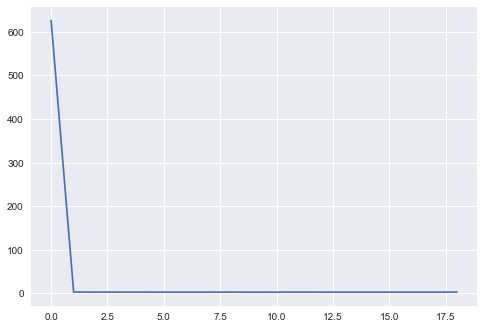

RMSLE: 0.679789
Accuracy: 32/256
[[ 300  540]
 [ 540  540]
 [ 540  960]
 [ 840  420]
 [ 420  360]
 [ 900 2700]
 [ 420  420]
 [ 840 1620]
 [ 540  840]
 [ 180  600]
 [ 420  840]
 [ 540  360]
 [ 900 2160]
 [ 840 1740]
 [ 660  720]
 [ 840  600]
 [ 360  480]
 [ 240  180]
 [ 540  360]
 [ 840 1320]
 [ 300  240]
 [ 180  120]
 [ 180  120]
 [ 540  540]
 [ 180    0]
 [ 300  420]
 [ 420  600]
 [ 240  240]
 [ 180  180]
 [ 900 1140]
 [ 300  300]
 [ 300  300]
 [ 840 1020]
 [ 840 1140]
 [ 900 2220]
 [ 900 1680]
 [ 240  240]
 [ 840  840]
 [ 240  180]
 [ 240  180]
 [ 840  360]
 [ 180  900]
 [ 840  780]
 [ 900  540]
 [ 840  720]
 [ 180  120]
 [ 300  240]
 [ 360  420]
 [ 180  180]
 [ 540  240]
 [ 840  600]
 [ 540  480]
 [ 300  420]
 [ 420  720]
 [ 840  420]
 [ 180  180]
 [ 540  720]
 [ 420  300]
 [ 180  180]
 [ 240  180]
 [ 420  540]
 [ 180 5400]
 [ 840  840]
 [ 180   60]
 [ 720  780]
 [ 900 1140]
 [ 420  600]
 [ 420 1560]
 [ 900 1080]
 [ 420  900]
 [ 540  360]
 [ 360  180]
 [ 540  600]
 [ 420  600]
 [ 36

In [60]:
plt.plot(errors)
plt.show()

np.set_printoptions(suppress=True, threshold=130000)

inputs_batch, labels_batch = batch.next_rows()
predicted_bins = sess.run(outputs, feed_dict={inputs: inputs_batch, actual_time: labels_batch})
predicted_values = np.matrix(np.argmax(predicted_bins, axis=1)) * 60
actual_values = np.matrix(np.argmax(labels_batch, axis=1)) * 60

print "RMSLE: %f" % np.mean(np.square(np.log(predicted_values+1) - np.log(actual_values+1))) 
print "Accuracy: %d/256" % np.sum(predicted_values == actual_values)
print np.concatenate([np.transpose(predicted_values), np.transpose(actual_values)], axis=1)
np.set_printoptions(suppress=False, threshold=100)